In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras as keras
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


# Define Functions

In [2]:
def read_data(file):
    """
    Read csv data from the specified file location.
    """
    df = pd.read_csv(file, index_col='Date')
    return df

In [3]:
def clip_recent_days(df, n_days):
    """
    -- optional --
    remove recent days from data frame
    """
    return(df[:-n_days])

In [4]:
def format_predictors_and_targets(df):
    
    """
    params: DataFrame with Predictors and Targets
    
    drop empty rows and prepare targets and predictors
    
    returns: formatted predictors, targets, and number of predictor columns
    
    """
    
    #drop rows with missing values
    df = df.dropna()
    
    # Extract Predictors
    predictors = df[['back_5', 'back_4', 'back_3', 'back_2', 'back_1']].values
    assert type(predictors) is np.ndarray
    
    # count number of predictive columns
    n_cols = predictors.shape[1]
    
    # extract target
    targets = df[['Adj Close']].values
    assert type(targets) is np.ndarray
    
    return predictors, targets, n_cols

In [5]:
# DEFINE DATA CONSTANTS
TEST_SIZE = 0.15

In [6]:
# specify location of time series data
file_path = '../data/interim/time_series.csv'

In [7]:
# read time series data
time_series_df = read_data(file_path)
time_series_df

,back_5,back_4,back_3,back_2,back_1,Adj Close
Date,,,,,,
1980-03-17,NaN,NaN,NaN,NaN,NaN,0.007326
1980-03-18,NaN,NaN,NaN,NaN,0.007326,0.014493
1980-03-19,NaN,NaN,NaN,0.007326,0.014493,-0.007220
1980-03-20,NaN,NaN,0.007326,0.014493,-0.007220,0.021506
1980-03-21,NaN,0.007326,0.014493,-0.007220,0.021506,-0.025136
...,...,...,...,...,...,...
2020-04-13,0.062380,0.013104,0.039586,0.085915,-0.045492,-0.027778
2020-04-14,0.013104,0.039586,0.085915,-0.045492,-0.027778,-0.050577
2020-04-15,0.039586,0.085915,-0.045492,-0.027778,-0.050577,-0.038855


In [8]:
time_series_df['Adj Close'] = (time_series_df['Adj Close']>=0.0)*1
time_series_df.describe()

,back_5,back_4,back_3,back_2,back_1,Adj Close
count,10104.000000,10105.000000,10106.000000,10107.000000,10108.000000,10109.000000
mean,0.000576,0.000573,0.000568,0.000565,0.000573,0.531111
std,0.022785,0.022785,0.022790,0.022792,0.022807,0.499056
min,-0.324614,-0.324614,-0.324614,-0.324614,-0.324614,0.000000
25%,-0.009636,-0.009638,-0.009656,-0.009661,-0.009661,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.010521,0.010520,0.010517,0.010514,0.010521,1.000000
max,0.223917,0.223917,0.223917,0.223917,0.223917,1.000000


In [9]:
# Inspect columns missing values
time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10109 entries, 1980-03-17 to 2020-04-17
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   back_5     10104 non-null  float64
 1   back_4     10105 non-null  float64
 2   back_3     10106 non-null  float64
 3   back_2     10107 non-null  float64
 4   back_1     10108 non-null  float64
 5   Adj Close  10109 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 552.8+ KB


In [10]:
# extract last row to predict tomorrow's change
tomorrow = time_series_df.iloc[[-1]].fillna(0)

# call function to format predictors and targets
tomorrow, _ , _ = format_predictors_and_targets(tomorrow)
predictors, targets, n_cols = format_predictors_and_targets(time_series_df)


In [11]:
# scale data to range [0,1]

# create scaler objects
X_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler = MinMaxScaler(feature_range=(0,1))

# fit respective scalers to data
predictors = X_scaler.fit_transform(predictors)
tomorrow = X_scaler.transform(tomorrow)
targets = y_scaler.fit_transform(targets)


In [12]:
# test for correct scaling
assert min(predictors.flatten()) == 0
assert max(predictors.flatten()) == 1
assert min(targets.flatten()) == 0
assert max(targets.flatten()) == 1

In [13]:
# split data into training set and testing set
# SHUFFLE = FALSE
X_train, X_test, y_train, y_test = train_test_split(predictors, targets, test_size=TEST_SIZE, shuffle=False, stratify=None, random_state=1)

# test for sequential split
assert np.argwhere(predictors == X_train[-1])[0][0] == (np.argwhere(predictors == X_test[0])[0][0]) -1
assert np.argwhere(predictors == y_train[-1])[0][0] == (np.argwhere(predictors == y_test[0])[0][0]) -1

In [14]:
# how many days of stock data are in the test set?
len(y_test)

1516

In [15]:
# re-shape predictors for keras model
tomorrow = np.reshape(tomorrow, (1, 1, tomorrow.shape[1]))
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

assert X_train.shape[1:] == tomorrow.shape[1:]

In [16]:
def build_sequential_LSTM(n_nodes, n_layers, add_dense):
    
    """
    Params: number of nodes in layers, number of LSTM layers, option to add Dense Layer
    
    Build a Sequential keras model with LSTM and optional Dense Layers
    
    Returns: Keras model with LSTM layers with minimum of 2 LSTM layers
    
    """
    
    # create Sequential model object
    model = Sequential()
    
    # add initial LSTM Layer
    model.add(LSTM(n_nodes, return_sequences=True, input_shape=X_train.shape[1:]))
    

    # add specified amount of additional LSTM layers
    for i in range(n_layers-2):
        model.add(LSTM(n_nodes, return_sequences=True))
    
    #return_sequences = False if next layer is not LSTM
    model.add(LSTM(n_nodes, return_sequences=False))
    
    
    if add_dense:
        # add optional Fully Connected Layer
        model.add(Dense(n_nodes, activation='relu'))
        
    # add Dense layer to produce output
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [17]:
# DEFINE MODEL CONSTANTS
N_NODES = 100
N_LAYERS = 3
ADD_DENSE = True

In [18]:
# build Sequential Model
model = build_sequential_LSTM(N_NODES, N_LAYERS, ADD_DENSE)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 100)            42400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 100)            80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,401
Trainable params: 213,401
Non-trainable params: 0
_________________________________________________________________


In [19]:
# DEFINE TRAINING CONSTANTS
EPOCHS = 1

In [20]:
# fit model to training data
model.fit(X_train, y_train, epochs=EPOCHS)

Epoch 1/1
8588/8588 [==============================] - 3s 377us/step - loss: 0.2631


In [21]:
# Make Predictions
predictions = model.predict(X_test)
tomorrows_prediction = model.predict(tomorrow)
print("Buy Stock: ", tomorrows_prediction>0.5)

Buy Stock:  [[ True]]


In [22]:
# inspect range of scaled predictions
print("Original Prediction Range:\t", min(predictions), max(predictions))
print("Expected Range:\t\t\t", min(y_test), max(y_test))

Original Prediction Range:	 [0.5069312] [0.55541736]
Expected Range:			 [0.] [1.]


# revert scaling
tomorrow_unscaled = y_scaler.inverse_transform(tomorrows_prediction)
unscaled_predictions = y_scaler.inverse_transform(predictions)
unscaled_y_test = y_scaler.inverse_transform(y_test)
print("Unscaled Prediction Range:\t", min(unscaled_predictions), max(unscaled_predictions))
print("Expected Range:\t\t\t", min(unscaled_y_test), max(unscaled_y_test))

# apply exponential function
exponential_tomorrow = np.exp(tomorrow_unscaled)
exponential_predictions = np.exp(unscaled_predictions)
exponential_y_test = np.exp(unscaled_y_test)
print("Exponential Prediction Range:\t", min(exponential_predictions), max(exponential_predictions))
print("Exponential Prediction Range:\t", min(exponential_y_test), max(exponential_y_test))

# Inspect quality of predictions
places = 4
min_pred = round(float(min(exponential_predictions)), places)
max_pred = round(float(max(exponential_predictions)), places)
mean_pred = round(float(np.mean(exponential_predictions)), places)
median_pred = round(float(np.median(exponential_predictions)), places)
percentile = round(np.percentile(exponential_predictions, 1.0), places)*100
print("min pred:\t", min_pred)
print("max pred:\t", max_pred)
print("mean pred:\t", mean_pred)
print("median pred:\t", median_pred)
print("percentile(1.0):", percentile)


is_good_model = min_pred<=1.0 and max_pred>=1.0
assert is_good_model

In [23]:
def get_accuracy(y, pred, thresh):
    
    """
    params: targets from the test set, model predictions
    
    Scores the model's ability to correctly predict the direction of change
    Magnitude of predicted changes is not scored.
    
    returns: model accuracy against the test set
    """
    #scale and shift binary results
    # -1 -> stock went down
    # +1 -> stock increased or stayed the same
    y = ((y>=thresh)*2)-1
    pred = ((pred>=thresh)*2)-1
    
    # stocks move in the same direction when a_i*b_i is positive
    accuracy = (np.sum((y*pred)>=0)/len(y))*100
    
    print("Predicting change in stock price with %f%s accuracy" % (accuracy,'%'))
    
    return accuracy

In [24]:
thresholds = [i/100 for i in range(5,100,5)]
accuracies = []
for thresh in thresholds:
    print("Decision Threshold: ", thresh)
    accuracy = get_accuracy(y_test, predictions, thresh)
    accuracies.append(accuracy)

Decision Threshold:  0.05
Predicting change in stock price with 52.308707% accuracy
Decision Threshold:  0.1
Predicting change in stock price with 52.308707% accuracy
Decision Threshold:  0.15
Predicting change in stock price with 52.308707% accuracy
Decision Threshold:  0.2
Predicting change in stock price with 52.308707% accuracy
Decision Threshold:  0.25
Predicting change in stock price with 52.308707% accuracy
Decision Threshold:  0.3
Predicting change in stock price with 52.308707% accuracy
Decision Threshold:  0.35
Predicting change in stock price with 52.308707% accuracy
Decision Threshold:  0.4
Predicting change in stock price with 52.308707% accuracy
Decision Threshold:  0.45
Predicting change in stock price with 52.308707% accuracy
Decision Threshold:  0.5
Predicting change in stock price with 52.308707% accuracy
Decision Threshold:  0.55
Predicting change in stock price with 47.427441% accuracy
Decision Threshold:  0.6
Predicting change in stock price with 47.691293% accurac

In [25]:
# consistently predicting with 52.3% accuracy

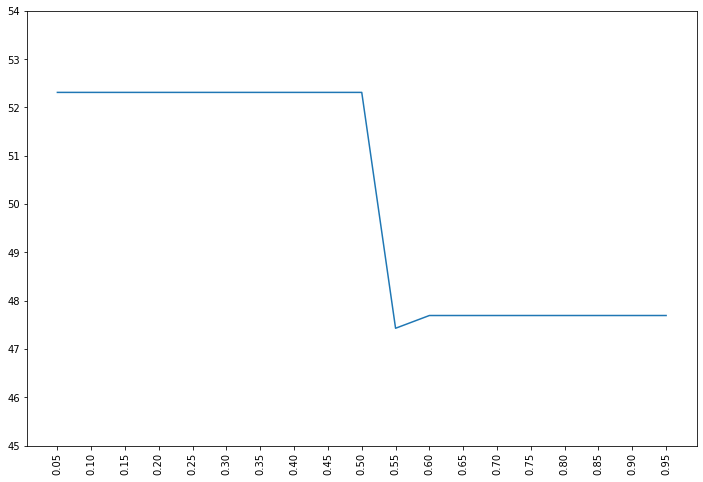

In [26]:
_ = plt.figure(figsize=(12, 8))
_ = plt.plot(thresholds, accuracies)
_ = plt.xticks(thresholds, rotation = 90)
_ = plt.yticks(range(45, 55, 1))
plt.show()